# Controller Tuning

## Learning Goals

Up to this point we have been discussing the theory and implementation of Proportional and Proportional-Integral control. The controllers have been specified with several parameters $K_p$, $K_I$, and the sampling time step. The purpose of this notebook is to describe methods for the practical determination of these parameters.

## Versions of P, PI, and PID Control

### Error Signal

The error signal measures the difference 

$$e(t) = SP(t) - PV(t)$$

### Idealized (Textbook) PID control

Textbook equations, Position Form

$$MV = \bar{MV} + \underbrace{K_P (SP - PV)}_{\text{proportional}} 
    + \underbrace{K_I \int^t (SP - PV) dt}_{\text{integral}}
    + \underbrace{K_D \frac{d}{dt}(SP-PV)}_{\text{derivative}}$$
    
Expressed with error signal
    
$$MV = \bar{MV} + \underbrace{K_P e(t)}_{\text{proportional}} 
    + \underbrace{K_I \int^t e(t) dt}_{\text{integral}}
    + \underbrace{K_D \frac{d}{dt}e(t)}_{\text{derivative}}$$


Discrete-time Version for TCLab

$$MV_k = \bar{MV} + \underbrace{K_P(SP_k - PV_k)}_{\text{proportional}} + \underbrace{\delta t K_I \sum^k (SP_k - PV_k)}_{\text{integral}}$$

* Proportional Control: Reduces system time constants. Too much leads to overshoot and excessive control action.
* Integral Control: Eliminates steady-state offset. Tends to slow-down and destablize control.
* Derivative Control: Mitigates fast changes in PV.  Not as important as P and PI for most process control applications.

### Practical PI Control

Problems with textbook control:

1. Position Form: How to choose $\bar{MV}$?
2. Reset (also called Integral) windup due to limits on manipulated variable.
3. Abrupt changes ("Bumps") on transition from manual to automatic control.

Three changes to the textbook control rule:

* **Velocity form**. Compute updates to $MV$
* **Anti-reset windup**. Limit MV to feasible limits. Use measured MV if available.
* **Bumpless transfer**. Leave SP out of the proportional control term.

Given parameters  $\delta t$, $K_P$, $K_I$, $MV_{min}$, $MV_{out}$

At each time step $ t + \delta t$

Using

* prior values $PV_{k-1}$
* current values for $PV_k$, $SP_k$, $MV_k$ (if available)

Compute

\begin{align*}
\\
E_k & = SP_k - PV_k & \text{error} \\
\\
\hat{MV}_{k} & = MV_{k-1} - K_p(PV_{k} - PV_{k-1}) - \delta t K_i E_{k} & \text{proposed update to MV}\\
\\
MV_k & = \max(MV^{min}, \min(MV^{max}, \hat{MV}_k)) & \text{limit MV to feasible values}
\end{align*}

## PI Control for Temperature Control Lab

The following sequence diagram shows the flow of information for one measure-compute-act-record cycle of the control system is shown in the following sequence diagram

![](figures/sequence-PID-1.png)

## PI Control with anti-reset windup and bumpless transfer

In [5]:
# add anti-integral windup feature.
def PI_bumpless(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    PV_prev = None
    while True:
        t_step, SP, PV, MV = yield MV 
        e = PV - SP
        if PV_prev is not None:
            MV += -Kp*(PV - PV_prev) - t_step*Ki*e 
            MV = max(MV_min, min(MV_max, MV))
        PV_prev = PV

## Event Loop with Disturbance Variable and Manual Control

In [6]:
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment_3(controller, t_final=1000, t_step=5,
               SP=lambda t: 40 if t >= 20 else 0, 
               DV=lambda t: 100 if t >= 420 else 0,
               MV=lambda t: 25 if t <= 100 else None):   # <== manipulated variable. Return none for auto
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
                   ("U1", lambda: U1), ("Q1", lab.Q1))
        h = Historian(sources)
        p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()
            if MV(t) is None:           
                U1 = controller.send((t_step, SP(t), T1, U1))    # automatic control
            else:
                U1 = MV(t)                                       # manual control
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)  
        h.to_csv("data.csv")

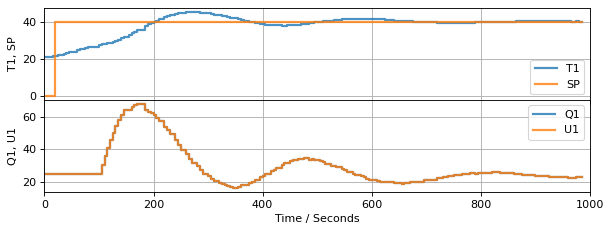

TCLab Model disconnected successfully.


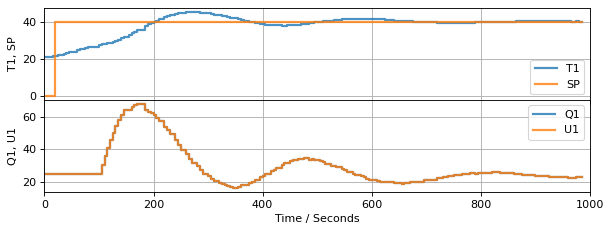

In [7]:
experiment_3(PI_bumpless(2, 0.1))

## Empirical Tuning Rules

There are a number of **tuning rules** in the literature that provide recommended values for the proportional gain $K_P$. These rules require process information obtained from testing. 

### Tuning Rules Based on Step Test Experiments

#### Step Test Procedure

1. Initialize experiment at a steady state. Confirm the process variable $PV$ is at a constant value $PV_1$. Eliminate any disturbances that might affect the test outcome.

2. Make a step change in the manipulated variable $MV_1 \rightarrow MV_2$

$$ \Delta MV = MV_2 - MV_1$$

3. Record the process variable $PV(t)$ until a new steady state $PV_2$ is reached.

$$ \Delta PV = PV_2 - PV_1 $$


#### Control Parameters

Using $PV(t)$ and the following chart, compute values for a first-order plus dead-time model parameters for gain ($K$), process time constant ($\tau$), and dead-time ($\theta$).
\begin{align*}
\\
K & = \frac{\Delta PV}{\Delta MV} & \text{gain} \\
\tau & & \text{first-order time constant} \\
\theta & & \text{dead time}
\end{align*}

![](https://cdn-images-1.medium.com/max/421/1*I4X51TgnOaR7CifBWmRFlA.png)

The Ziegler-Nichols estimates for the proportional and integral gain are then computed from the following tuning rules. Astrom and Hagglunc (200\6) provide an updated "improved" formula for these parameters.

| Type | $K_P$ | $K_I$ |
| :---: | :---: | :---: |
| P (Ziegler-Nichols) | $\frac{\tau}{K\theta}$ | |
| PI (Ziegler-Nichols) | $\frac{0.9 \tau}{K\theta}$ | $\frac{0.3\tau}{K\theta^2}$ |
| PI (Astrom and Hagglund, 2006) | $\frac{0.15\theta + 0.35\tau}{K\theta}$ | $\frac{0.46\theta + 0.02\tau}{K\theta^2}$ |

#### Evaluate Control Performance

Tuning rules are developed based on acheiving some performance criteria. Typical criteria include measures liks

\begin{align}
\text{IAE} & = \int_0^{\infty} |e(t)|dt \qquad \text{Integral Absolute Error}\\
\text{ISE} & = \int_0^{\infty} |e(t)|^2dt \qquad \text{Integral Square Error}\\
\text{ITAE} & = \int_0^{\infty} t|e(t)|dt \qquad \text{Integral Time Absolute Error}\\
\end{align}

Among the best known and commonly used tuning rules are listed in the following table (also see Astrom and Murray, Chapter 11):


### Tuning Rules based on Closed Loop Testing

For strong theoretical and practical reasons, closed-loop experiments can provide superior results for tuning P, PI, and PID controllers. The easiest closed-loop tuning experiment is to implement simple relay control. The following code cells demonstrate relay control suitable for the identification experiment. 

Experimental requirements:

1. Conduct the experiment long enough to ensure steady cycling about a constant setpoint.

2. Choose MV_min and/or MV_max to so the MV is "on" approximately 50% of the time.  

$$\Delta MV = MV_{max} - MV_{min}$$

3. Determine $\Delta PV$ from peak-to-peak amplitude of the oscillation in $PV$. The "critical gain" is

$$K_c = (\frac{4}{\pi}) \frac{\Delta MV}{\Delta PV}$$
 
4. Determine the "critical period" $T_c$ by measuring the period of oscillation.

| Type | $K_P$ | $K_I$ |
| :---: | :---: | :---: |
| P (Ziegler-Nichols) | $0.5 K_c$ | |
| PI (Ziegler-Nichols) | $0.4 K_c$ | $0.5\frac{K_c}{T_c}$ |

5. Implement and test the resulting controller.


In [32]:
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment_4(controller, t_final=1000, t_step=5, SP=lambda t: 40 if t >= 20 else 0):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
                   ("U1", lambda: U1), ("Q1", lab.Q1))
        h = Historian(sources)
        p = Plotter(h, 200, layout=[("T1", "SP"), ("Q1", "U1")])

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()
            U1 = controller.send((t_step, SP(t), T1, U1))    # automatic control
            lab.Q1(U1)
            p.update(t)  

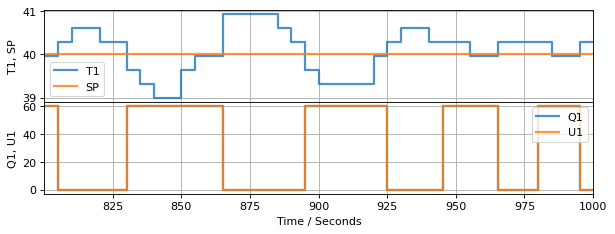

TCLab Model disconnected successfully.


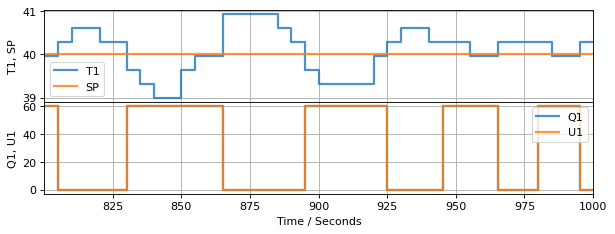

In [33]:
def Relay(MV_bar=0, MV_min=0, MV_max=60):
    MV = MV_bar
    while True:
        t_step, SP, PV, MV = yield MV 
        e = PV - SP
        if PV < SP:
            MV = MV_max
        else:
            MV = MV_min  
            
experiment_4(Relay())

## Lab Assignment 5

You will test PI controllers tuned using Step Test experiment and a closed-loop Relay experiment. For testing, use the Chocolate tempering setpoint profile you developed for Lab Assignment 5.

1. Perform the Step Test experiment desribed above. Report the following results.

    * The code used to perform the experiment. 
    * Calculations of $K$, $\tau$, and $\theta$.
    * PI Parameter $K_P$ and $K_I$ determined using the "improved" tuning rules.
    * The code and results of applying this controller to the Chocolate tempering setpoint used in Lab Assignment 4. This time, leave heater 2 off.

2. Repeat the previous steps using closed-loop relay control to determine critical gain $K_c$ and critical period $T_c$. Report the PI Control parameters and experimental verification for the Chocolate tempering setpoint.